In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
COLS = ["CorsikaId","px","py","pz","xprime","yprime","t",
        "shower_id","prm_id","prm_energy","prm_theta","prm_phi"]

## Creating a function to do the data wrangling for all the data sets

In [3]:
def wrangle(file_path):
    df = pd.read_csv(file_path, # path
                 comment="#", # ignore comments
                 sep=' ',# separation is space
                 header=None, # no other header set
                 names=COLS, # the name of the columns
                 engine="python" 
    )
    # subsetting the data for only muons and resetting the index
    muons = (df["CorsikaId"] == 5) | (df["CorsikaId"] == 6)
    df = df[muons].reset_index()

    # computing the zenith angle in radians
    df['p'] = np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2)
    df['theta_rad'] = np.arccos(df['pz'] / df['p'])  # zenith angle in radians 

    # theta radians in degrees
    df['theta'] = np.rad2deg(df['theta_rad'])


    return df


In [4]:
chyulu = wrangle("chyulu_1500_E2_T300.shw")
chyulu.head()

,index,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,3,6,0.239349,2.10079,2.296850,-3053.400,-1505.760,955.091,3,703,148.480,40.463,77.817,3.121879,0.744057,42.631329
1,16,5,-1.272300,1.27893,0.918181,17808.700,-8674.940,925.210,11,703,313.859,69.078,137.309,2.024220,1.099998,63.025269
2,17,6,1.290790,-2.03940,1.993120,-1490.890,1766.450,955.581,12,703,578.559,55.199,-59.310,3.130147,0.880521,50.450122
3,19,5,1.244550,-2.61563,2.097410,-721.249,146.217,955.958,12,703,578.559,55.199,-59.310,3.576249,0.944086,54.092153
4,20,5,0.576436,-1.23215,0.901144,-663.201,1114.510,955.868,12,703,578.559,55.199,-59.310,1.631727,0.985719,56.477529


In [5]:
lyon = wrangle("lyon_1500_E2_T300.shw")
lyon.head()

,index,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,3,6,0.15869,0.479482,2.09849,-360.194,-662.494,955.955,2,703,94.2717,9.859,63.925,2.158413,0.236186,13.532446
1,25,6,-26.41510,-26.015400,11.92270,531.210,2213.870,955.593,3,703,3186.8200,72.763,-133.557,38.944952,1.259658,72.173095
2,27,6,-9.05384,-8.473120,4.30432,522.129,3629.930,954.945,3,703,3186.8200,72.763,-133.557,13.126041,1.236693,70.857291
3,28,5,-16.49450,-18.675400,7.21289,198.235,-3381.670,955.100,3,703,3186.8200,72.763,-133.557,25.939639,1.289018,73.855284
4,29,5,-8.65452,-10.628300,4.14904,1547.420,-3745.960,954.711,3,703,3186.8200,72.763,-133.557,14.320475,1.276854,73.158339


Comparing the graphs

In [6]:
def cos_squared_model(theta_deg, I0):
    """Cosine-power model with n fixed at 3: I(theta) = I0 * cos^2(theta)"""
    theta_rad = np.deg2rad(theta_deg)
    return I0 * np.cos(theta_rad)**2

In [7]:
# generating 100 values from 0 to 90 
theta_range = np.linspace(0, 90, 100)
 # binning the zenith angle
bins = np.arange(0, 91, 10)

Fitted I0 with n=3: 70.631 (in arbitrary units)
Fitted I0 with n=3: 71.601 (in arbitrary units)


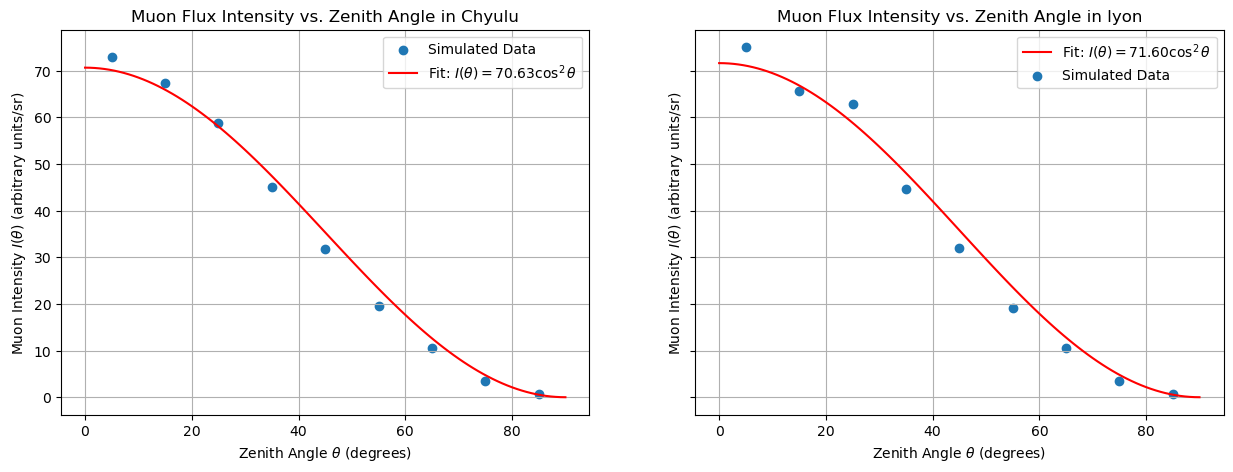

In [ ]:
# creating the 3 plots in one row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True, sharex=True)

# zenith angles for chyulu
counts, bin_edges = np.histogram(chyulu['theta'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# calculating solid angle
bin_edges_rad = np.deg2rad(bin_edges) 
solid_angles = 2 * np.pi * (np.cos(bin_edges_rad[:-1]) - np.cos(bin_edges_rad[1:]))

# calculating flux intensity (input how long the simulation was running)
time = float(input("How long did the simulation run in Chyulu(s): "))
flux_intensity = counts / time / solid_angles



# fitting the binned data
try:
    popt, pcov = curve_fit(cos_squared_model, bin_centers, flux_intensity, p0=[1.0])
    I0_fit = popt[0]
    print(f"Fitted I0 with n=3: {I0_fit:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit = 1.0 # Default value if fit fails

# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit)


#plotting the curve on the same plot as 
axes[0].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[0].scatter(bin_centers, flux_intensity, label='Simulated Data')


# plotting the graph
axes[0].set_title('Muon Flux Intensity vs. Zenith Angle in Chyulu')
axes[0].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[0].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[0].legend()
axes[0].grid(True)

# ------------------------------------------------------------------------------

# zenith angles for lyon
counts_chyulu, bin_edges_chyulu = np.histogram(lyon['theta'], bins=bins)
bin_centers_chyulu = (bin_edges_chyulu[:-1] + bin_edges_chyulu[1:]) / 2.0

# calculating solid angle
bin_edges_rad_c = np.deg2rad(bin_edges_chyulu) 
solid_angles_chyulu = 2 * np.pi * (np.cos(bin_edges_rad_c[:-1]) - np.cos(bin_edges_rad_c[1:]))

# calculating flux intensity (input how long the simulation was running)
time_chyulu = float(input("How long did the simulation run in lyon(s): "))
flux_intensity_chyulu = counts_chyulu / time_chyulu / solid_angles_chyulu

# fitting the binned data
try:
    popt_chyulu, pcov_chyulu = curve_fit(cos_squared_model, bin_centers_chyulu, flux_intensity_chyulu, p0=[1.0])
    I0_fit_chyulu = popt_chyulu[0]
    print(f"Fitted I0 with n=3: {I0_fit_chyulu:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit_chyulu = 1.0 # Default value if fit fails


# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit_chyulu)


#plotting the curve on the same plot as 
axes[1].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit_chyulu:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[1].scatter(bin_centers_chyulu, flux_intensity_chyulu, label='Simulated Data')


# plotting the graph
axes[1].set_title('Muon Flux Intensity vs. Zenith Angle in lyon')
axes[1].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[1].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[1].legend()
axes[1].grid(True)

# Print all graphs
plt.tight_layout
plt.show()

The difference in Muons in Chyulu and Lyon

In [9]:
lyon.columns

Index(['index', 'CorsikaId', 'px', 'py', 'pz', 'xprime', 'yprime', 't',
       'shower_id', 'prm_id', 'prm_energy', 'prm_theta', 'prm_phi', 'p',
       'theta_rad', 'theta'],
      dtype='object')

In [10]:
print("--Lyon 1500m E2 Time 300 secs-- \n")
# groupby
top_shower_id_lyon = lyon["CorsikaId"].groupby(lyon["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_lyon = len(lyon)
print(f"Total Muon Distribution {muon_distribution_lyon} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_lyon}")

--Lyon 1500m E2 Time 300 secs-- 

Total Muon Distribution 41994 

Number  of unique shower ids in 22677

 Top ten shower ids in lyon 
 shower_id
3726     736
7853     276
34507    196
35898    186
43897    167
470      153
910      135
24197    104
1060      98
953       84
Name: CorsikaId, dtype: int64


In [12]:
print("--Chyulu 1500m E2 Time 300 secs-- \n")
# groupby
top_shower_id_chyulu = chyulu["CorsikaId"].groupby(chyulu["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_chyulu = len(chyulu)
print(f"Total Muon Distribution {muon_distribution_chyulu} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_chyulu}")

--Chyulu 1500m E2 Time 300 secs-- 

Total Muon Distribution 41621 

Number  of unique shower ids in 22677

 Top ten shower ids in lyon 
 shower_id
35231    188
32090    156
7191     134
1022     122
576      120
813       93
5546      91
1087      83
42024     81
11370     70
Name: CorsikaId, dtype: int64
